https://www.kaggle.com/lucamassaron/eda-target-analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 原链接中用的pd.read_feather，但是没能下载他的数据集，所以用的是code1的数据和方法
train = pd.read_parquet("../train_low_mem.parquet")

In [4]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [5]:
time_steps, assets = train.time_id.nunique(), train.investment_id.nunique()
print(f"number of assets: {assets} \t time steps: {time_steps}")

number of assets: 3579 	 time steps: 1211


In [6]:
print(f"number of assets: {assets} (range from {train.investment_id.min()} to {train.investment_id.max()})")

number of assets: 3579 (range from 0 to 3773)


The range of assets is more extended than the number fo assets themselves. In fact, assets will change in part in the test set, therefore you have to consider strategies for handling the ones in the training set in a generalizable way. See: https://www.kaggle.com/c/ubiquant-market-prediction/discussion/301693#1656092

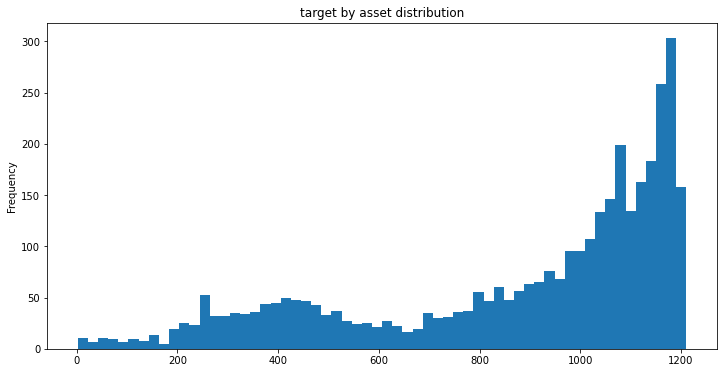

In [7]:
obs_by_asset = train.groupby(['investment_id'])['target'].count()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
obs_by_asset.plot.hist(bins=60)
plt.title("target by asset distribution")
plt.show()

上图可以看出，不同investment的数量有所差异

下图：如果您更仔细地按时间查看资产结构，您会注意到相当多的不连续性，并且这些不连续性更多地出现在时间的第一部分。

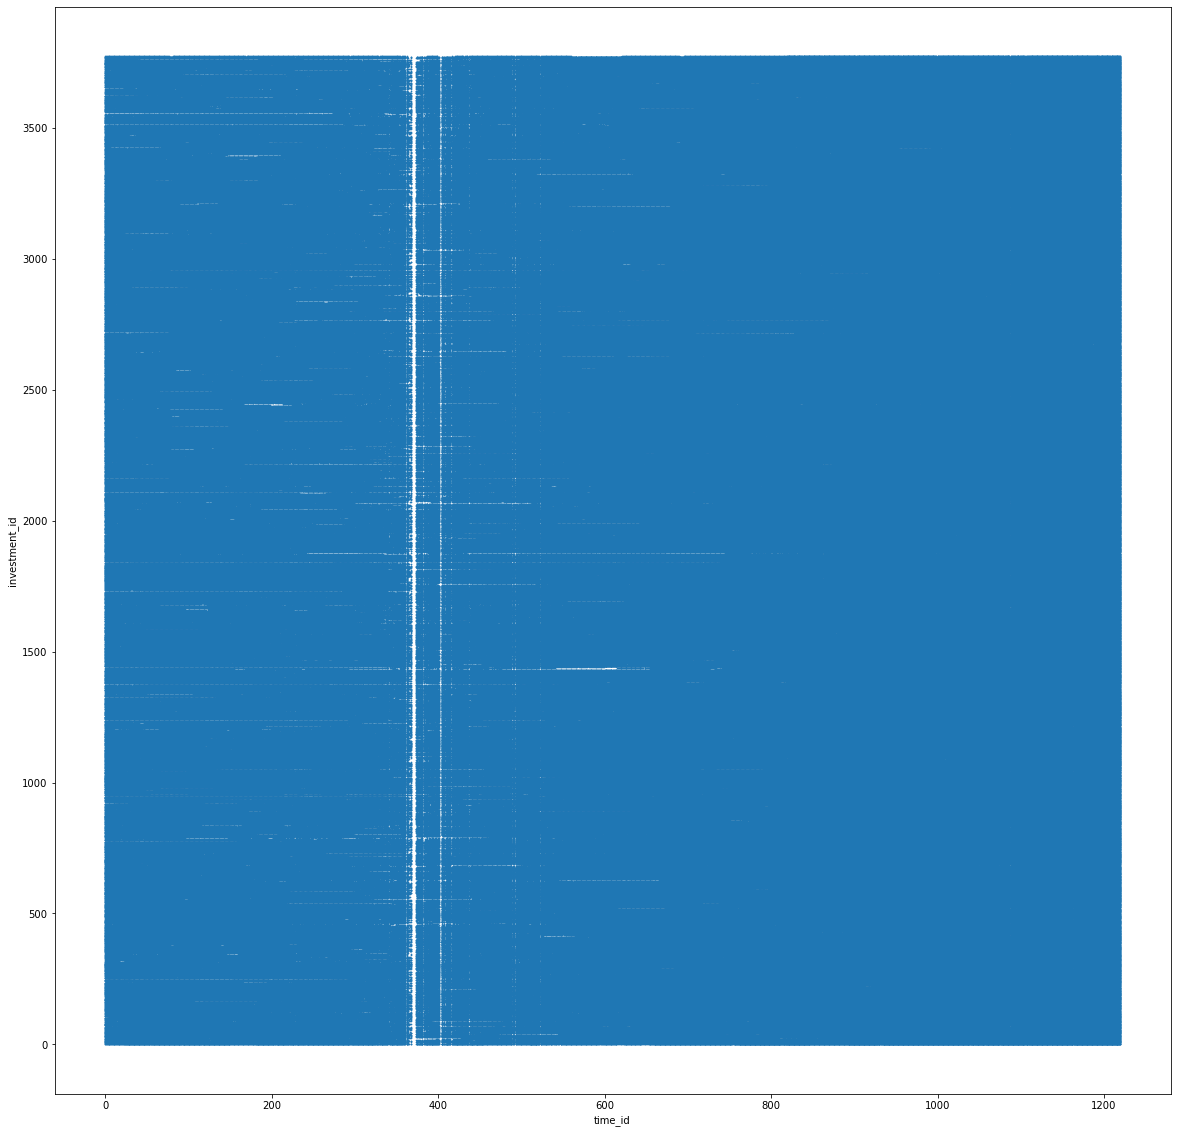

In [16]:
train[["investment_id", "time_id"]].plot.scatter("time_id", "investment_id", figsize=(20, 20), s=0.5)
plt.show()

Assets are distributed in a different way, there are assets that are actually more frequently observed and others that are not. A good cv and modelling strategy should keep this into account (stratify if you are working with subsamples).

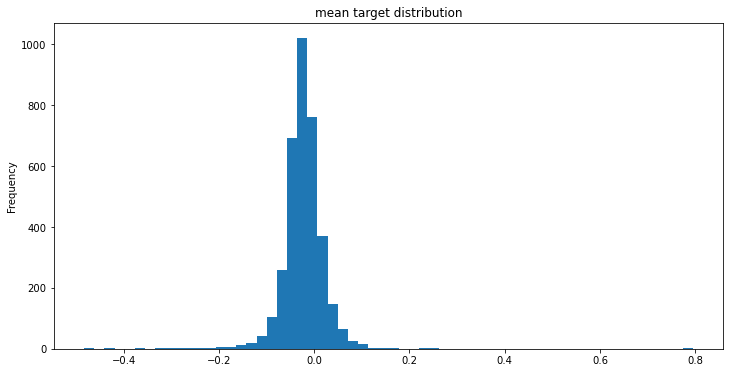

Mean of mean target: -0.02310


In [13]:
mean_target = train.groupby(['investment_id'])['target'].mean()
mean_mean_target = np.mean(mean_target)
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
mean_target.plot.hist(bins=60)
plt.title("mean target distribution")
plt.show()
print(f"Mean of mean target: {mean_mean_target: 0.5f}")

investment对应的多个target的平均值 呈钟形分布，但要注意存在异常值，因为有些资产的平均目标非常负（-0.4 区域），有些资产的平均目标非常正（+0.8 区域）。 总体而言，按资产划分的平均平均目标略为负（-0.0231）

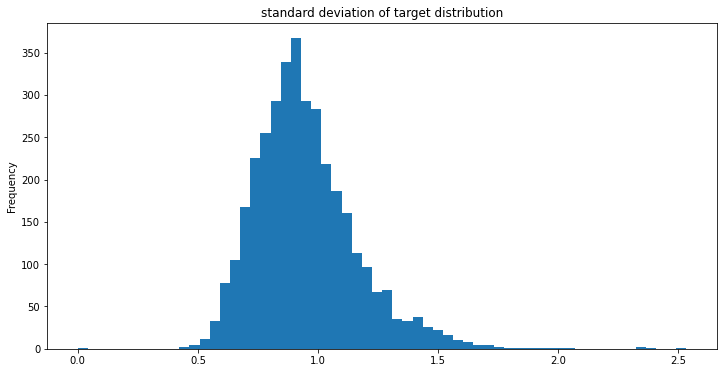

Mean of std target:  0.94790


In [19]:
std_target = train.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(std_target)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
std_target.plot.hist(bins=60)
plt.title("standard deviation of target distribution")
plt.show()

print(f"Mean of std target: {mean_std_target: 0.5f}")

此外，可以看出，资产的平均标准偏差 (std) 的平均值呈现出一些有趣的模式。 首先，它向右倾斜，一些资产的标准值更高（最高为 2.5）。 另一方面，也有一些资产的标准差几乎为零。

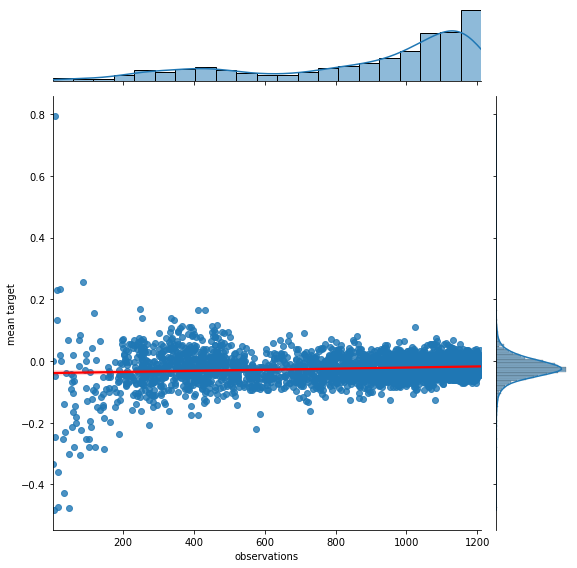

In [24]:
ax = sns.jointplot(x=obs_by_asset, y=mean_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('mean target')
plt.show()

通过联合绘制按资产的观察分布和按资产的平均目标值，我们可能会注意到目标值与观察次数成比例地略有下降。 随着观察次数的减少，值的分散趋于增长，因此我们这次需要使用标准偏差重新绘制散点图。

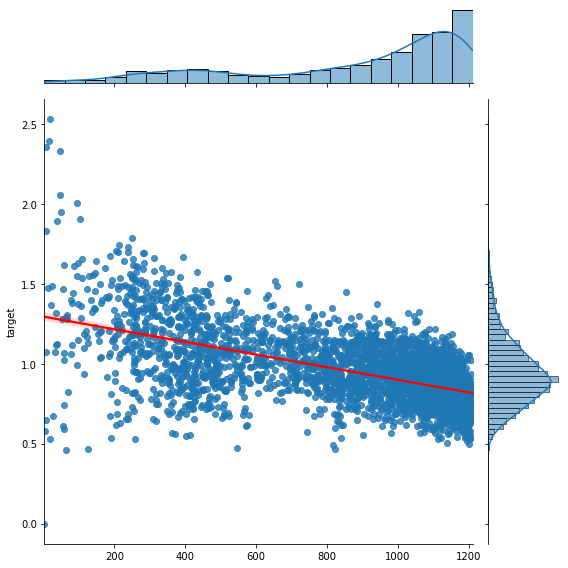

In [23]:
qx = sns.jointplot(x=obs_by_asset.values, y=std_target, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
ax.ax_joint.set_xlabel('observations')
ax.ax_joint.set_ylabel('std target')
plt.show()

新的散点图显示，观测值越少，意味着平均目标的不确定性越大。

策略：在训练中，您需要通过明确观察次数来控制这种影响，因为这可以预测预测的不确定性。 相反，在测试阶段，当您使用您不了解的资产时，您需要估算平均观察次数，从而预期该资产的预测平均分散。

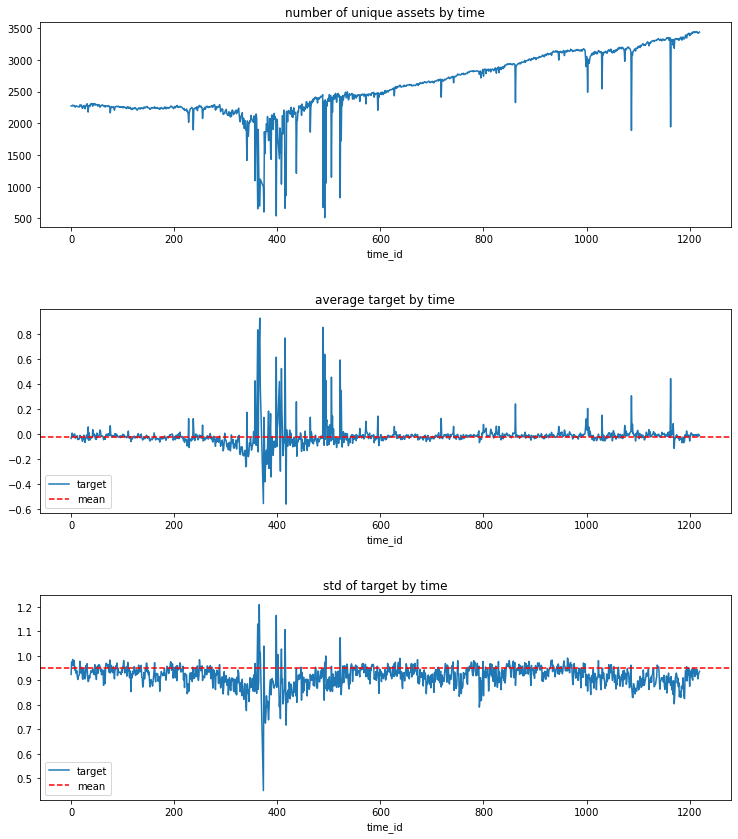

In [35]:
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
train.groupby('time_id')['investment_id'].nunique().plot()
plt.title("number of unique assets by time")

plt.subplot(3, 1, 2)
train.groupby('time_id')['target'].mean().plot()
plt.title("average target by time")
plt.axhline(y=mean_mean_target, color='r', linestyle='--', label='mean')
plt.legend(loc='lower left')

plt.subplot(3, 1, 3)
train.groupby('time_id')['target'].std().plot()
plt.title("std of target by time")
plt.axhline(y=mean_std_target, color='r', linestyle='--', label="mean")
plt.legend(loc='lower left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

正如我们已经推断出观察较少的投资似乎风险更大，我们注意到每个时间步长存在的资产数量是如何完全不同的，并且也是高度波动的。 到可用时间结束时，资产数量增长了三分之一。

In [36]:
r = np.corrcoef(train.groupby('time_id')['investment_id'].nunique(), train.groupby('time_id')['target'].mean())[0][1]
print(f"Correlation of number of assets by target: {r:0.3f}")

Correlation of number of assets by target: -0.184


如果我们将资产数量与时间平均目标一起绘制，则很明显，当资产较少时，目标会随着普遍较高的目标而波动更大。 事实上，资产数量和目标的相关性是负相关的。 我想知道我们是否正在与市场一起模拟资产配置策略。

现在让我们更仔细地观察目标和时间之间的关系：